In [224]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

### Read Time Series Data For BTC to USD

In [225]:
frame = pd.read_csv("data/BTC-USD-1yr.csv")
opens = np.array(frame["Open"]) # a time series index for opening price per day
closes = np.array(frame["Close"]) # a time series index for close price at day's end

In [273]:
def daily_return(t0, t1):
    delta = np.log(t1 / t0)
    return delta

### Aggregate Statistics For Sample and Theoretical Population

In [227]:
daily_returns = np.array(list(map(lambda x : daily_return(x[0], x[1]), zip(opens, closes))))
days = len(daily_returns)
average_return = np.sum(daily_returns) / days
realized_volatility = np.sum((daily_returns - average_return ) ** 2) / (days - 1) # variance of daily returns

print(average_return, realized_volatility)
days

0.002727460446629683 0.0005331999127978996


367

(array([  3.,   9.,  12.,  50., 175.,  71.,  26.,  13.,   4.,   4.]),
 array([-0.07854512, -0.06136647, -0.04418782, -0.02700917, -0.00983052,
         0.00734813,  0.02452678,  0.04170543,  0.05888408,  0.07606273,
         0.09324138]),
 <BarContainer object of 10 artists>)

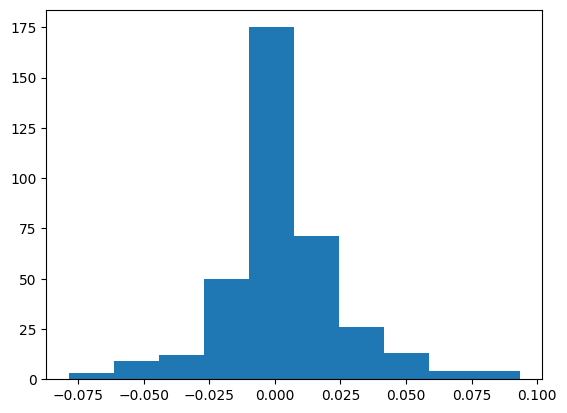

In [271]:
plt.hist(daily_returns)

# daily returns should follow a normal distribution as the limit of the sample size approaches infinity in accordance 
# with the Central Limit Theorem.

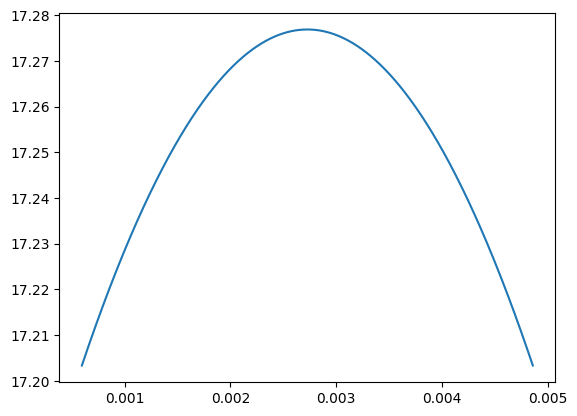

In [229]:
x = np.linspace(average_return - 4*realized_volatility, average_return + 4*realized_volatility, 1000)
pdf_values = norm.pdf(x, average_return, np.sqrt(realized_volatility))
plt.plot(x, pdf_values)

### Compute The Implied Volatility at each T_n for T_n + 1

#### For each day the standard deviation needs to adhere to  $$[ \sigma^2 = \frac{1}{N-1} \sum_{t=1}^{N} (R_t - \bar{R})^2 ]$$




In [411]:
realized_vols_per_day = [0]
day = 1
rolling_mean = daily_returns[0]
rolling_returns = [daily_returns[0]]

# we must recompute vol per day since mu changes
def compute_realized_volatility(returns, mean):
    n = len(returns)
    return np.sum((returns - mean) ** 2) / (n - 1)

# computes the daily realized volatility so we can use mean squared error to test the regression error
for d in range(1, len(daily_returns)):
    r = daily_returns[d]
    day += 1
    rolling_mean = ((rolling_mean * (day - 1)) + r) / day
    rolling_returns.append(r)
    rv = compute_realized_volatility(rolling_returns, rolling_mean)
    realized_vols_per_day.append(rv)

realized_vols_per_day

[0,
 0.0004050852480735594,
 0.0012316126453683776,
 0.0008521116651415563,
 0.0006699260148602809,
 0.0005419138552354135,
 0.00045392507247215717,
 0.0004243886970079008,
 0.0007264783873234599,
 0.0006486722460119875,
 0.0006983993685808257,
 0.0011995112343144187,
 0.0017472397736064264,
 0.0016381335091940122,
 0.0015500767143165253,
 0.0014830789201874547,
 0.001819932731254471,
 0.0017553088523027548,
 0.0017067603092836016,
 0.0016365593006596923,
 0.0015562115349916279,
 0.0015546655615442408,
 0.0015222563120696518,
 0.0015178350670496934,
 0.0014564727637201987,
 0.001402976515179575,
 0.0014032515946055249,
 0.001351307575221283,
 0.0013407438165395171,
 0.0013055520292672915,
 0.0012649018565909472,
 0.0012265504729765684,
 0.00119568333930125,
 0.0011711597324762738,
 0.0011385403565884586,
 0.0011067802467249336,
 0.0010787791643511015,
 0.0010518408474981735,
 0.00102455484865135,
 0.0010001899388368902,
 0.0010150218510193312,
 0.0009945505129088877,
 0.000972919052833

### Aggregate Trends in Realized Volatility Per Day

In [395]:
def linear_regression(x,y):
    # linear least squares minimizes the error for (Alpha) * x + Beta
    xs = np.vstack([np.ones(len(x)), x]).T
    return np.linalg.lstsq(xs, y, rcond = None)[0]

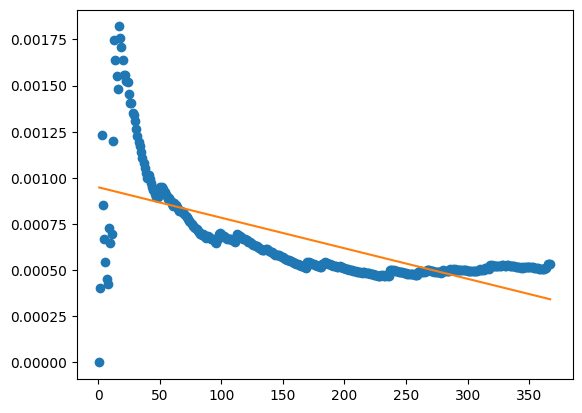

In [396]:
days_axis = np.array([d for d in range(1, day + 1)])
y_intercept, slope = linear_regression(days_axis , np.array(realized_vols_per_day))
plt.plot(days_axis, realized_vols_per_day,'o')
plt.plot(days_axis, (slope * days_axis) + y_intercept)

#### Find the Implied Volatility for the next day relative to each day with linear regression

In [397]:
implied_volatility = []
current_realized_volatility = [0]
days = [1]

for rv in range(1, len(realized_vols_per_day)):
    # at each day we will have the actual realized volatility so there is no need to rely on previous implied data for regression
    _, delta_v = linear_regression(np.array(days), np.array(current_realized_volatility))
    implied_volatility.append( realized_vols_per_day[rv - 1] + delta_v )
    current_realized_volatility.append(realized_vols_per_day[rv])
    days.append(days[-1] + 1)

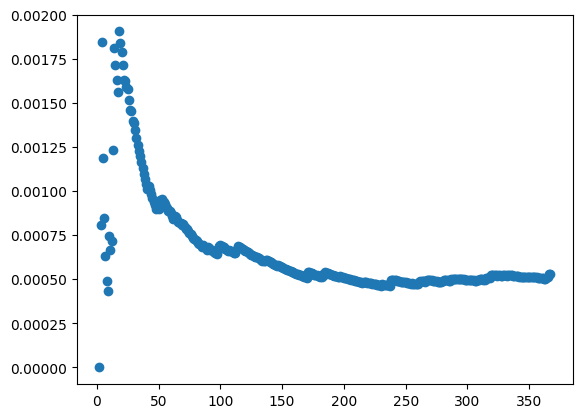

In [401]:
plt.plot(np.array(days[1:]), np.array(implied_volatility), 'o')

In [390]:
def mean_squared_error(x1, x2):
    return sum(map(lambda vec: (vec[0] - vec[1]) ** 2, zip(x1, x2))) / (len(x1) - 1)

### Mean Squared Error for full data regression

In [406]:
mean_squared_error(realized_vols_per_day, implied_volatility)
# mean square error is still surprisingly close to zero despite the data looking hyperbolic

2.18351373076234e-09

## Find an optimally sized regression window that minimizes mean_squared_error

In [407]:
# Utility data structure for LRU sliding window
from collections import deque

class CircularQ:
    """
    A Circular Buffer that serves as a simple sliding window
    """
    def __init__(self, size):
        self.size = size
        self.buff = []
        self.idx = 0

    def add(self, item):
        if len(self.buff) < self.size:
            self.buff.append(item)
        else:
            self.buff[self.idx % self.size] = item
            
        self.idx += 1

    def __iter__(self):
        if len(self.buff) < self.size:
            for i in self.buff:
                yield i
        else:
            # yield everything after index and then before to preserve lru order
            pivot = self.idx % self.size
            for d in range(pivot, len(self.buff)):
                yield self.buff[d]
            for d in range(pivot):
                yield self.buff[d]



In [408]:
buff = CircularQ(6)
for i in range(9):
    buff.add(i)
if [x for x in buff] != [3,4,5,6,7,8]:
    raise ValueError("failed simple unit test for in order print out", buff.buff)
else:
    print("Test Passed", buff.buff)


buff2 = CircularQ(5)
for i in range(4):
    buff2.add(i)
if [b for b in buff2] != [0,1,2,3]:
    raise ValueError("failed simple unit test for in order print out", buff2.buff)
else:
    print("Test Passed", buff2.buff)


buff3 = CircularQ(7)
for i in range(7):
    buff3.add(i)
if [b for b in buff3] != [0,1,2,3,4,5,6]:
    raise ValueError("failed simple unit test for in order print out", buff3.buff)
else:
    print("Test Passed", buff3.buff)

Test Passed [6, 7, 8, 3, 4, 5]
Test Passed [0, 1, 2, 3]
Test Passed [0, 1, 2, 3, 4, 5, 6]


### Simulation

In [417]:
min_error = float("inf")
min_window_size = 0 
min_iv = []

def conduct_experiment(q):
    local_iv = []
    q.add(realized_vols_per_day[0])
    
    for idx in range(1, len(realized_vols_per_day)):
        y_axis = [r for r in q]
        x_axis = [x for x in range(1, len(y_axis) + 1)]
        _, delta_v = linear_regression(x_axis, y_axis)
        local_iv.append( realized_vols_per_day[idx - 1] + delta_v)
        q.add(realized_vols_per_day[idx])
        
    return mean_squared_error(realized_vols_per_day, local_iv), local_iv


aggregate_err, _ = conduct_experiment(CircularQ(400))
print(aggregate_err)

for window in range(2, day):
    q = CircularQ(window)
    mse, lv = conduct_experiment(q)
    if mse < min_error:
        min_error = mse
        min_window_size = window
        min_iv = lv

print(min_window_size, min_error)


2.18351373076234e-09
117 2.180776564196496e-09


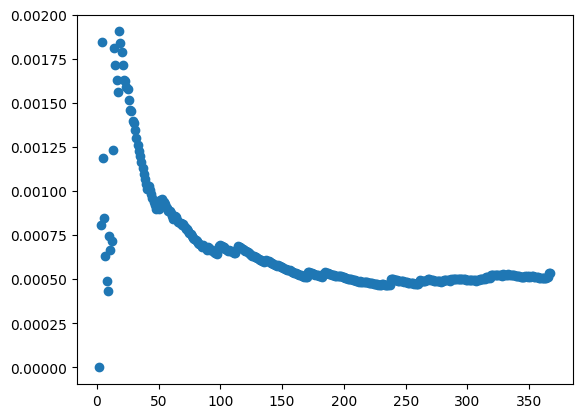

In [418]:
plt.plot(np.array(days[1:]), np.array(min_iv), 'o')